# Interpretable drift detection with the spot-the-diff detector on MNIST and Wine-Quality datasets

Under the hood drift detectors leverage a function of the data that is expected to be large when drift has occured and small when it hasn't. In the [Learned drift detectors on CIFAR-10](https://docs.seldon.io/projects/alibi-detect/en/latest/examples/cd_clf_cifar10.html) example notebook we note that we can **learn** a function satisfying this property by training a classifer to distinguish reference and test samples. However we now additionally note that if the classifier is specified in a certain way then when drift is detected we can inspect the weights of the classifier to shine light on exactly which features of the data were used to distinguish reference from test samples and therefore caused drift to be detected. 

The `SpotTheDiffDrift` detector is designed to make this process straightforward. Like the `ClassifierDrift` detector, it uses a portion of the available data to train a classifier to discriminate between reference and test instances. Letting $\hat{p}_T(x)$ represent the probability assigned by the classifier that the instance $x$ is from the test set rather than reference set, the difference here is that we use a classifier of the form $$\text{logit}(\hat{p}_T) = b_0 + b_1 k(x,w_1) + ... + b_Jk(x,w_J),$$ where $k(\cdot,\cdot)$ is a kernel specifying a notion of similarity between instances, $w_i$ are learnable *test locations* and $b_i$ are learnable regression coefficients.

The idea here is that if the detector flags drift and $b_i >0$ then we know that it reached its decision by considering how similar each instance is to the instance $w_i$, with those being more similar being more likely to be test instances than reference instances. Alternatively if $b_i < 0$ then instances more similar to $w_i$ were deemed more likely to be reference instances.

In order to provide less noisy and therefore more interpretable results, we define each test location as $$w_i = \bar{x}+d_i$$ where $\bar{x}$ is the mean reference instance. We may then interpret $d_i$ as the additive transformation deemed to make the average reference more ($b_i>0$) or less ($b_i<0$) similar to a test instance. Defining the test locations in this way allows us to instead learn the difference $d_i$ and apply regularisation such that non-zero values must be justified by improved classification performance.  This allows us to more clearly identify which features any detected drift should be attributed to.

This approach to interpretable drift detection is inspired by the work of [Jitkrittum et al. (2016)](https://arxiv.org/abs/1605.06796), however several major adaptations have been made.

### Backend

The method works with both the PyTorch and TensorFlow frameworks. Alibi Detect does however not install PyTorch for you. Check the PyTorch docs how to do this.

### Dataset

We start with an image example in order to provide a visual illustration of how the detector works. For this prupose we use the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) of 28 by 28 grayscale handwritten digits. To represent the common problem of new classes emerging during the deployment phase we consider a reference set of ~9,000 instances containing only the digits 1-9 and a test set of 10,000 instances containing all of the digits 0-9. We would like drift to be detected in this scenario because a model trained of the reference instances will not know how to process instances from the new class.

This notebook requires the `torchvision` package which can be installed via `pip`:

In [1]:
!pip install torchvision

In [2]:
import torch
import tensorflow as tf
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from alibi_detect.cd import SpotTheDiffDrift

np.random.seed(0)
torch.manual_seed(0)
tf.random.set_seed(0)
%matplotlib inline

In [8]:
MNIST_PATH = 'my_path'
DOWNLOAD = True
MISSING_NUMBER = 0
N = 10000

# Load and shuffle data
mnist_train_ds = torchvision.datasets.MNIST(MNIST_PATH, train=True, download=DOWNLOAD)
all_x, all_y = mnist_train_ds.data, mnist_train_ds.targets
perm = np.random.permutation(len(all_x))
all_x, all_y = all_x[perm], all_y[perm]
all_x = all_x[:, None, : , :].numpy().astype(np.float32)/255.

# Create a reference and test set
x_ref = all_x[:N]
x = all_x[N:2*N]

# Remove a class from reference set
x_ref = x_ref[all_y[:10000] != MISSING_NUMBER]

When instantiating the detector we should specify the number of "diffs" we would like it to use to discriminate reference from test instances. Here there is a trade off. Using `n_diffs=1` is the simplest to interpret and seems to work well in practice. Using more diffs may result in stronger detection power but the diffs may be harder to interpret due to intereactions and conditional dependencies.

The strength of the regularisation (`l1_reg`) to apply to the diffs should also be specified. Stronger regularisation results in sparser diffs as the classifier is encouraged to discriminate using fewer features. This may make the diff more interpretable but may again come at the cost of detection power.

We should also specify how the classifier should be trained with standard arguments such as `learning_rate`, `epochs` and `batch_size`. By default a [Gaussian RBF](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) is used for the kernel but alternatives can be specified via the `kernel` kwarg. Additionally the classifier can be initialised with any desired diffs by passing them with the `initial_diffs` kwarg -- by default they are initialised with Gaussian noise with standard deviation equal to that observed in the reference data.

In [4]:
cd = SpotTheDiffDrift(
    x_ref,
    n_diffs=1,
    l1_reg=1e-4,
    backend='tensorflow',
    verbose=1,
    learning_rate=1e-2, 
    epochs=5, 
    batch_size=64,
)

When we then call the detector to detect drift on the deployment/test set it trains the classifier (thereby learning the diffs) and the usual `is_drift` and `p_val` properties can be inspected in the usual way:

In [5]:
preds = cd.predict(x)

print(f"Drift? {'Yes' if preds['data']['is_drift'] else 'No'}")
print(f"p-value: {preds['data']['p_val']}")

222/222 [=] - 2s 8ms/step - loss_ma: 0.6818
Drift? Yes
p-value: 6.911625415497573e-09


As expected, the drift was detected. However we may now additionally look at the learned diffs and corresponding coefficients to determine how the detector reached this decision.

Diff coeff: [2.6694217]


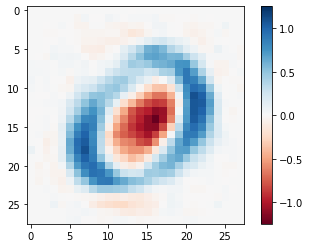

In [9]:
print(f"Diff coeff: {preds['data']['diff_coeffs']}")
diff = preds['data']['diffs'][0,0]
plt.imshow(diff, cmap='RdBu', vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
plt.colorbar()

The detector has identified the zero that was missing from the reference data -- it realised that test instances were on average **more** (coefficient > 0) simmilar to an instance with below average middle pixel values and above average zero-region pixel values than reference instances were. It used this information to determine that drift had occured. 

## Interpretable Drift Detection on the Wine Quality Dataset

To provide an example on tabular data we consider the [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/wine+quality) consisting of 4898 and 1599 samples of white and red wine respectively. Each sample has an associated quality (as determined by experts) and 11 numeric features indicating its acidity, density, pH etc. To represent the problem of a model being trained on one distribution and deployed on a subtly different one, we take as a reference set the samples of white wine and consider the red wine samples to form a 'corrupted' deployment set.

In [10]:
import pandas as pd
red_df = pd.read_csv(
    "https://storage.googleapis.com/seldon-datasets/wine_quality/winequality-red.csv", sep=';'
)
white_df = pd.read_csv(
    "https://storage.googleapis.com/seldon-datasets/wine_quality/winequality-white.csv", sep=';'
)
white_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


We can see that the data for both red and white wine samples take the same format.

In [11]:
red_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


We extract the features and shuffle and normalise them such that they take values in \[0,1\].

In [12]:
white, red = np.asarray(white_df, np.float32)[:, :-1], np.asarray(red_df, np.float32)[:, :-1]
n_white, n_red = white.shape[0], red.shape[0]

col_maxes = white.max(axis=0)
white, red = white / col_maxes, red / col_maxes
white, red = white[np.random.permutation(n_white)], red[np.random.permutation(n_red)]
x, x_corr = white, red

We then split off half of the reference set to act as an unseen sample from the same underlying distribution for which drift should *not* be detected.

In [13]:
x_ref = x[:len(x)//2]
x_h0 = x[len(x)//2:]

We instantiate our detector in the same way as we do above, but this time using the *Pytorch* backend for the sake of variety. We then get the predictions of the detector on both the undrifted and corrupted test sets.

In [14]:
cd = SpotTheDiffDrift(
    x_ref,
    n_diffs=1,
    l1_reg=1e-4,
    backend='pytorch',
    verbose=1,
    learning_rate=1e-2, 
    epochs=5, 
    batch_size=64,
)

preds_h0 = cd.predict(x_h0)
preds_corr = cd.predict(x_corr)

No GPU detected, fall back on CPU.


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [15]:
print(f"Drift on h0? {'Yes' if preds_h0['data']['is_drift'] else 'No'}")
print(f"p-value on h0: {preds_h0['data']['p_val']}")
print(f"Drift on corrupted? {'Yes' if preds_corr['data']['is_drift'] else 'No'}")
print(f"p-value on corrupted:: {preds_corr['data']['p_val']}")

Drift on h0? No
p-value on h0: 0.5436501149526445
Drift on corrupted? Yes
p-value on corrupted:: 2.3583165511991543e-203


As expected drift is detected on the red wine samples but not the held out white wine samples from the same distribution. Now we can inspect the returned diff to determine how the detector reached its decision

Diff coeff: [-1.870848]


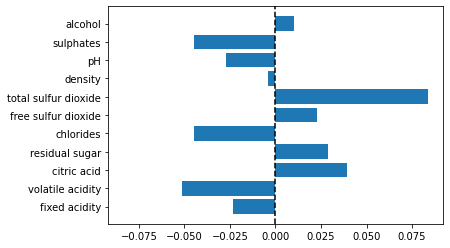

In [16]:
diff = preds_corr['data']['diffs'][0]
print(f"Diff coeff: {preds_corr['data']['diff_coeffs']}")
plt.barh(white_df.columns[:-1], diff)
plt.xlim((-1.1*np.max(np.abs(diff)), 1.1*np.max(np.abs(diff))))
plt.axvline(0, linestyle='--', color='black')
plt.show()

We see that the detector was able to discriminate the corrupted (red) wine samples from the reference (white) samples by noting that on average reference samples (coeff < 0) typically contain more sulfur dioxide and residual sugars but have less sulphates and chlorides and have lower pH and volatile and fixed acidity.